<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/eeg_mac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of anesthetic concentration from EEG
In this example, we will build a model to predict anesthetic concentration (age-related MAC) from EEG during Sevoflurane anesthesia.

> Note that <b>all users who use Vital DB, an open biosignal dataset, must agree to the Data Use Agreement below.
</b> If you do not agree, please close this window.
Click here: [Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.vcpgs1yemdb5)

## Required libraries

In [17]:
!pip install vitaldb
import vitaldb
import random
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt

## Preprocessing

In [18]:
SRATE = 128  # in hz
SEGLEN = 2 * SRATE  # segment samples
MAX_CASES = 100

df_trks = pd.read_csv("https://api.vitaldb.net/trks")  # track information
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # patient information

# track names and column order when loading data
track_names = ['BIS/EEG1_WAV', 'Primus/EXP_SEVO', 'BIS/BIS']
EEG = 0
SEVO = 1
BIS = 2

# Inclusion & Exclusion criteria
caseids = set(df_cases.loc[df_cases['age'] > 18, 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'BIS/EEG1_WAV', 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'BIS/BIS', 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'Primus/EXP_SEVO', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Primus/EXP_DES', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Orchestra/PPF20_CE', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Orchestra/RFTN50_CE', 'caseid'])
caseids = list(caseids)
print(f'Total {len(caseids)} cases found')
#random.shuffle(caseids)

x = []  # eeg
y = []  # sevo
b = []  # bis
c = []  # caseids
icase = 0  # number of loaded cases
for caseid in caseids:
    print(f'loading caseid={caseid} ({icase + 1}/{MAX_CASES})', end='...', flush=True)

    # extract data
    vals = vitaldb.load_case(caseid, track_names, 1 / SRATE)
    if np.nanmax(vals[:, SEVO]) < 1:
        print('all sevo < 1%')
        continue

    # convert etsevo to the age related mac
    age = df_cases.loc[df_cases['caseid'] == caseid, 'age'].values[0]
    vals[:, SEVO] /= 1.80 * 10 ** (-0.00269 * (age - 40))

    # exclude cases without bis
    if not np.any(vals[:, BIS] > 0):
        print('all bis <= 0')
        continue

    # exclude cases with use of SEVO shorter than 30 min
    valid_idx = np.where(vals[:, SEVO] > 0.1)[0]
    first_idx = valid_idx[0]
    last_idx = valid_idx[-1]
    if last_idx - first_idx < 1800 * SRATE:
        print('len sevo < 30 min')
        continue
    vals[:first_idx, SEVO] = 0

    # trim cases with BIS
    valid_idx = np.where(vals[:, BIS] > 0)[0]
    first_idx = valid_idx[0]
    last_idx = valid_idx[-1]
    vals = vals[first_idx:last_idx + 1, :]

    # exclude cases shorter than 30 min
    if len(vals) < 1800 * SRATE:
        print('len bis < 30 min')
        continue

    # forward fill in MAC value and BIS value up to 7 sec
    vals[:, SEVO:] = pd.DataFrame(vals[:, SEVO:]).ffill(limit=7*SRATE).values

    # extract 2-sec segments
    oldlen = len(y)
    for isamp in range(SEGLEN, len(vals), SRATE * 2):
        bis = vals[isamp, BIS]
        mac = vals[isamp, SEVO]
        if np.isnan(bis) or np.isnan(mac) or bis == 0:
            continue
        # add to dataset
        eeg = vals[isamp - SEGLEN:isamp, EEG]
        x.append(eeg)
        y.append(mac)
        b.append(bis)
        c.append(caseid)

    # print results
    icase += 1
    print(f'{len(y) - oldlen} segments read -> total {len(y)} segments ({icase}/{MAX_CASES})')
    if icase >= MAX_CASES:
        break

# Change the input dataset to a numpy array
x = np.array(x)
y = np.array(y)
b = np.array(b)
c = np.array(c)

Total 1518 cases found
loading 2 (1/100)...7278 segments read -> total 7278 segments (1/100)
loading 4 (2/100)...9861 segments read -> total 17139 segments (2/100)
loading 10 (3/100)...10050 segments read -> total 27189 segments (3/100)
loading 12 (4/100)...14684 segments read -> total 41873 segments (4/100)
loading 18 (5/100)...all bis <= 0
loading 21 (5/100)...5637 segments read -> total 47510 segments (5/100)
loading 24 (6/100)...2497 segments read -> total 50007 segments (6/100)
loading 25 (7/100)...6742 segments read -> total 56749 segments (7/100)
loading 27 (8/100)...8016 segments read -> total 64765 segments (8/100)
loading 33 (9/100)...1927 segments read -> total 66692 segments (9/100)
loading 43 (10/100)...6865 segments read -> total 73557 segments (10/100)
loading 49 (11/100)...len sevo < 30 min
loading 56 (11/100)...13726 segments read -> total 87283 segments (11/100)
loading 58 (12/100)...6841 segments read -> total 94124 segments (12/100)
loading 61 (13/100)...4072 segmen

## Filtering input data

In [19]:
# exclude segments
print('invalid samples...', end='', flush=True)
valid_mask = ~(np.max(np.isnan(x), axis=1) > 0) # if there is nan
valid_mask &= (np.nanmax(x, axis=1) - np.nanmin(x, axis=1) > 12)  # bis impedence check
valid_mask &= (np.nanmax(np.abs(x), axis=1) < 100)  # noisy sample
x = x[valid_mask]
y = y[valid_mask]
b = b[valid_mask]
c = c[valid_mask]
print(f'{100*(1-np.mean(valid_mask)):.1f}% removed')

invalid samples...

<ipython-input-19-03c63be541e1>:4: RuntimeWarning: All-NaN slice encountered
  valid_mask &= (np.nanmax(x, axis=1) - np.nanmin(x, axis=1) > 12)  # bis impedence check
<ipython-input-19-03c63be541e1>:5: RuntimeWarning: All-NaN slice encountered
  valid_mask &= (np.nanmax(np.abs(x), axis=1) < 100)  # noisy sample


9.1% removed


## Splitting samples into training and testing dataset

In [20]:
# caseid
caseids = list(np.unique(c))
random.shuffle(caseids)

# Split dataset into training and testing data
ntest = max(1, int(len(caseids) * 0.2))
caseids_train = caseids[ntest:]
caseids_test = caseids[:ntest]

train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)
x_train = x[train_mask]
y_train = y[train_mask]
x_test = x[test_mask]
y_test = y[test_mask]
b_test = b[test_mask]
c_test = c[test_mask]

print('====================================================')
print(f'total: {len(caseids)} cases {len(y)} samples')
print(f'train: {len(np.unique(c[train_mask]))} cases {len(y_train)} samples')
print(f'test {len(np.unique(c_test))} cases {len(y_test)} samples')
print('====================================================')

total: 100 cases 516791 samples
train: 80 cases 407819 samples
test 20 cases 108972 samples


## Modeling and Evaluation

In [24]:
import keras.models
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer, LayerNormalization, Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

out = inp = Input(shape=(x_train.shape[1], 1))
for i in range(4):
    out = Conv1D(filters=32, kernel_size=7, padding='same')(out)
    out = Activation('relu')(out)
    out = MaxPooling1D(2, padding='same')(out)
out = GlobalMaxPooling1D()(out)
out = Dense(128)(out)
out = Dense(1)(out)

model = Model(inputs=[inp], outputs=[out])
model.summary()
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
# fit model. the last 20% of the segments will be used for early stopping
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=4096,
                callbacks=[ModelCheckpoint(monitor='val_loss', filepath='model.x', verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')])

# prediction
pred_test = model.predict(x_test).flatten()
for caseid in np.unique(c_test):
    case_mask = (c_test == caseid)
    pred_test[case_mask] = scipy.signal.medfilt(pred_test[case_mask], 15)

# calculate the performance
test_mae = np.mean(np.abs(y_test - pred_test))

# pearson correlation coefficient
bis_corr = np.corrcoef(y_test, b_test)[0, 1]
our_corr = np.corrcoef(y_test, pred_test)[0, 1]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 1)]          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 256, 32)           256       
                                                                 
 activation_12 (Activation)  (None, 256, 32)           0         
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 128, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 128, 32)           7200      
                                                                 
 activation_13 (Activation)  (None, 128, 32)           0         
                                                           

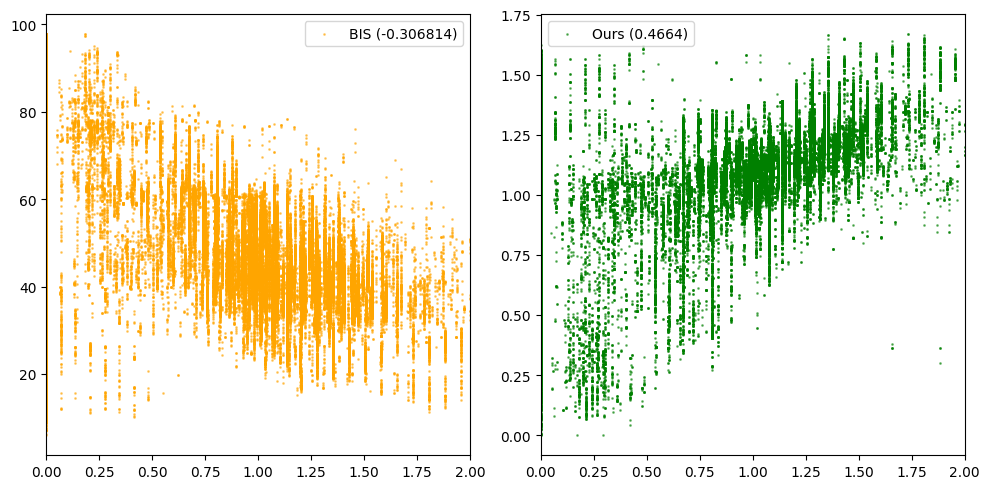

In [22]:
# scatter plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, b_test, s=1, alpha=0.5, c='orange', label=f'BIS ({bis_corr:4f})')
plt.xlim([0, 2])
plt.legend(loc="upper right")
plt.subplot(1, 2, 2)
plt.scatter(y_test, pred_test, s=1, alpha=0.5, c='green', label=f'Ours ({our_corr:.4f})')
plt.xlim([0, 2])
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

Total MAE=0.3646, CaseID 2, MAE=0.1715


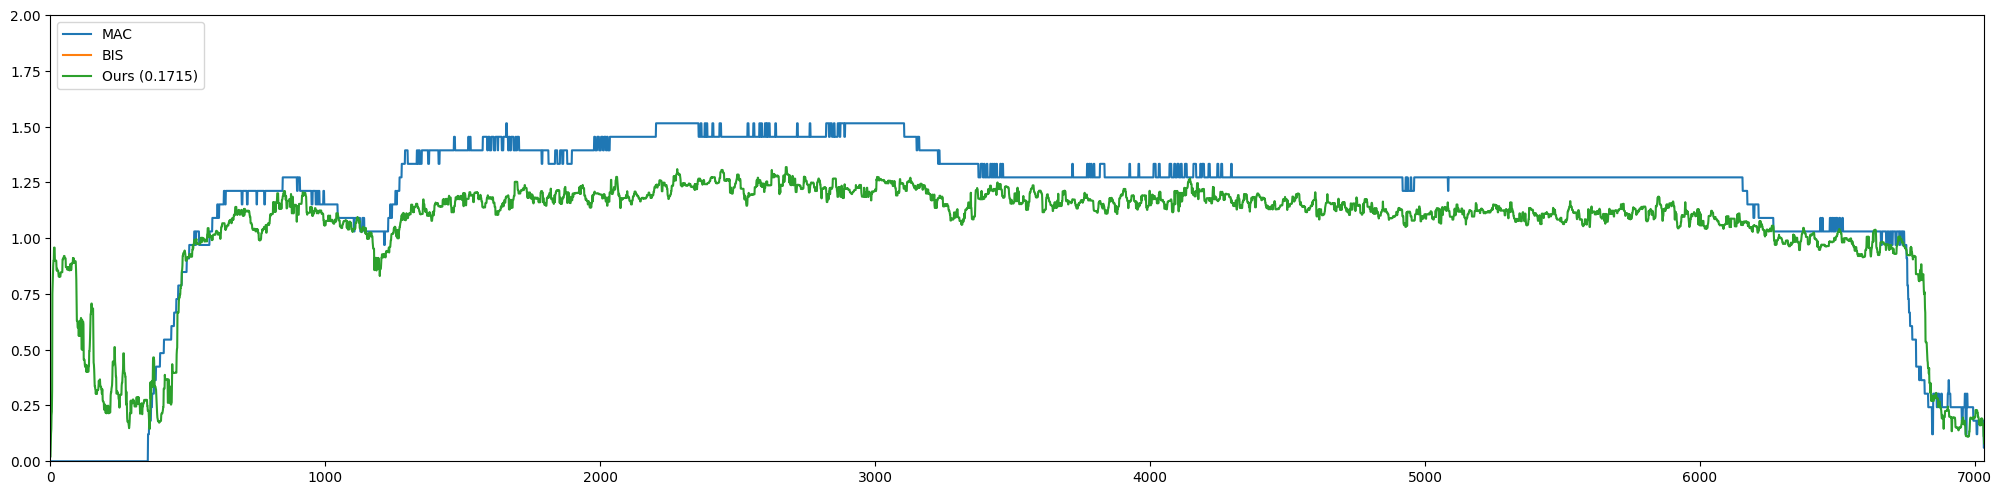

Total MAE=0.3646, CaseID 12, MAE=0.1672


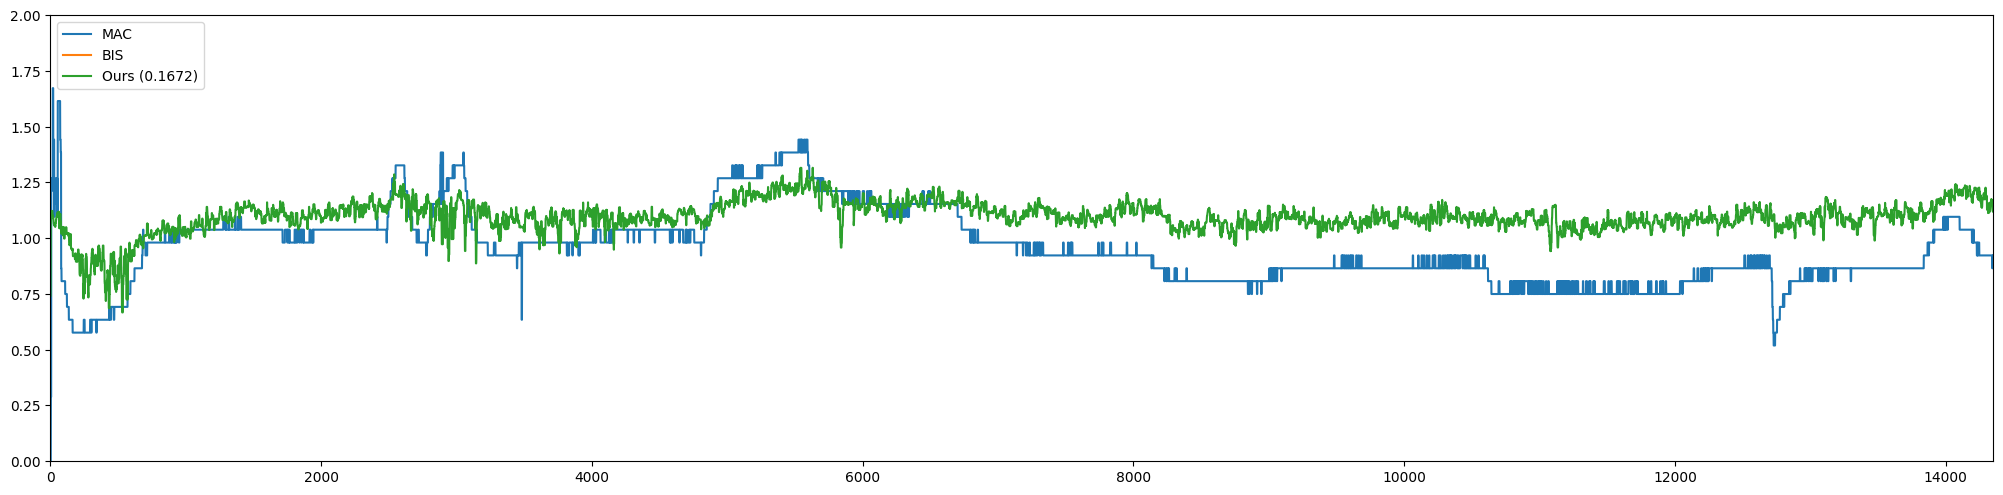

Total MAE=0.3646, CaseID 76, MAE=0.1218


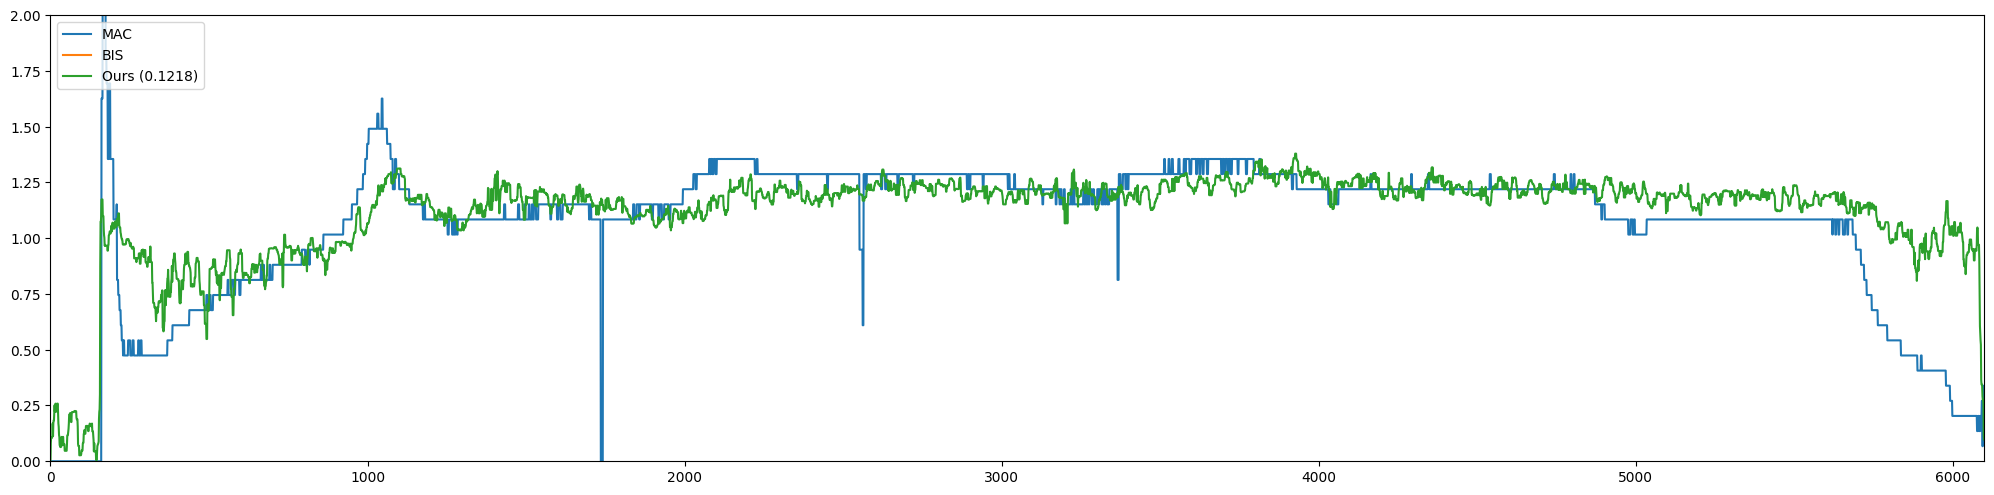

Total MAE=0.3646, CaseID 84, MAE=0.1459


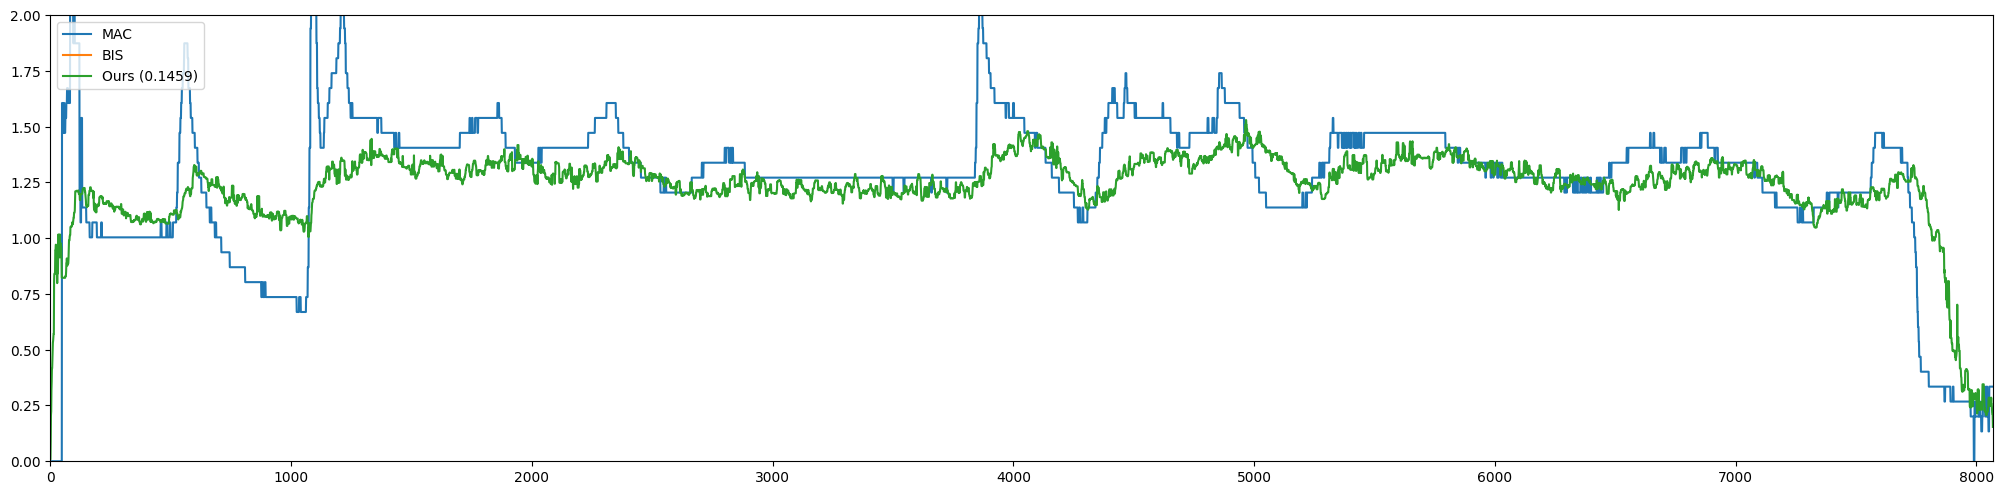

Total MAE=0.3646, CaseID 87, MAE=0.3214


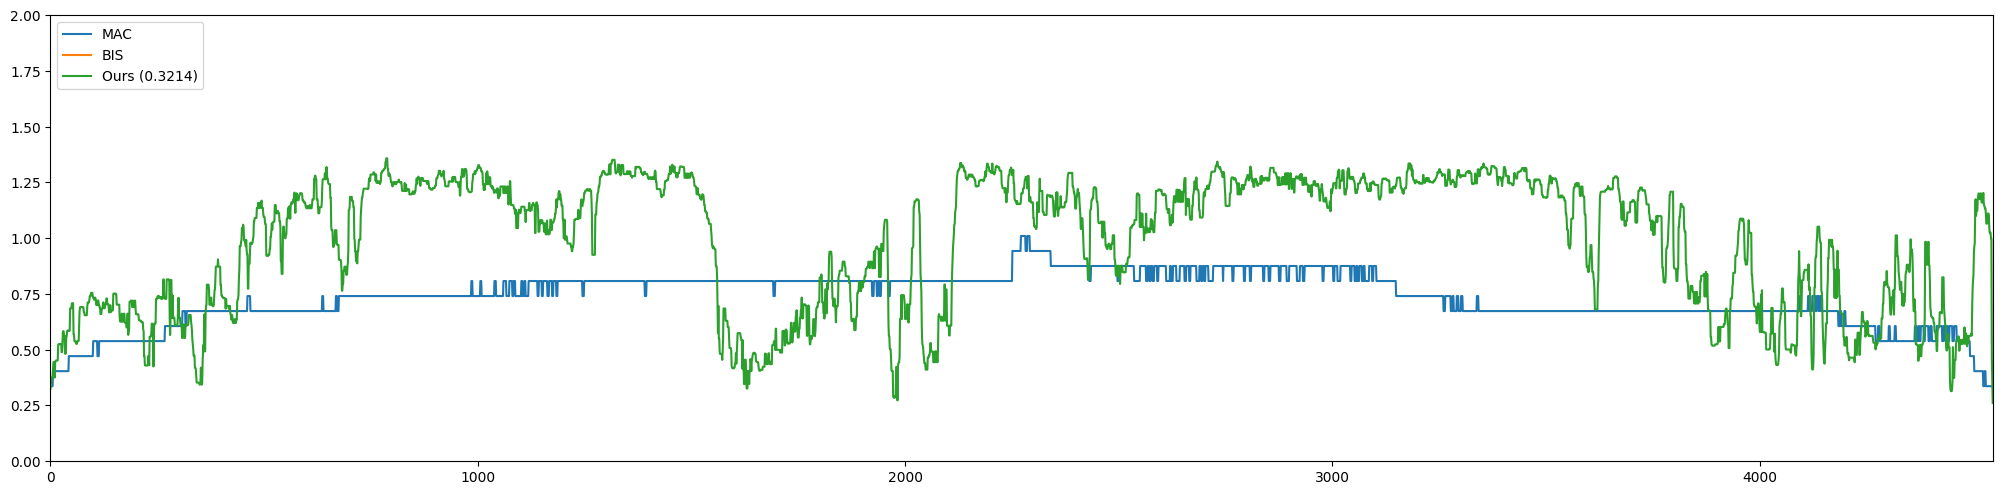

Total MAE=0.3646, CaseID 91, MAE=0.1582


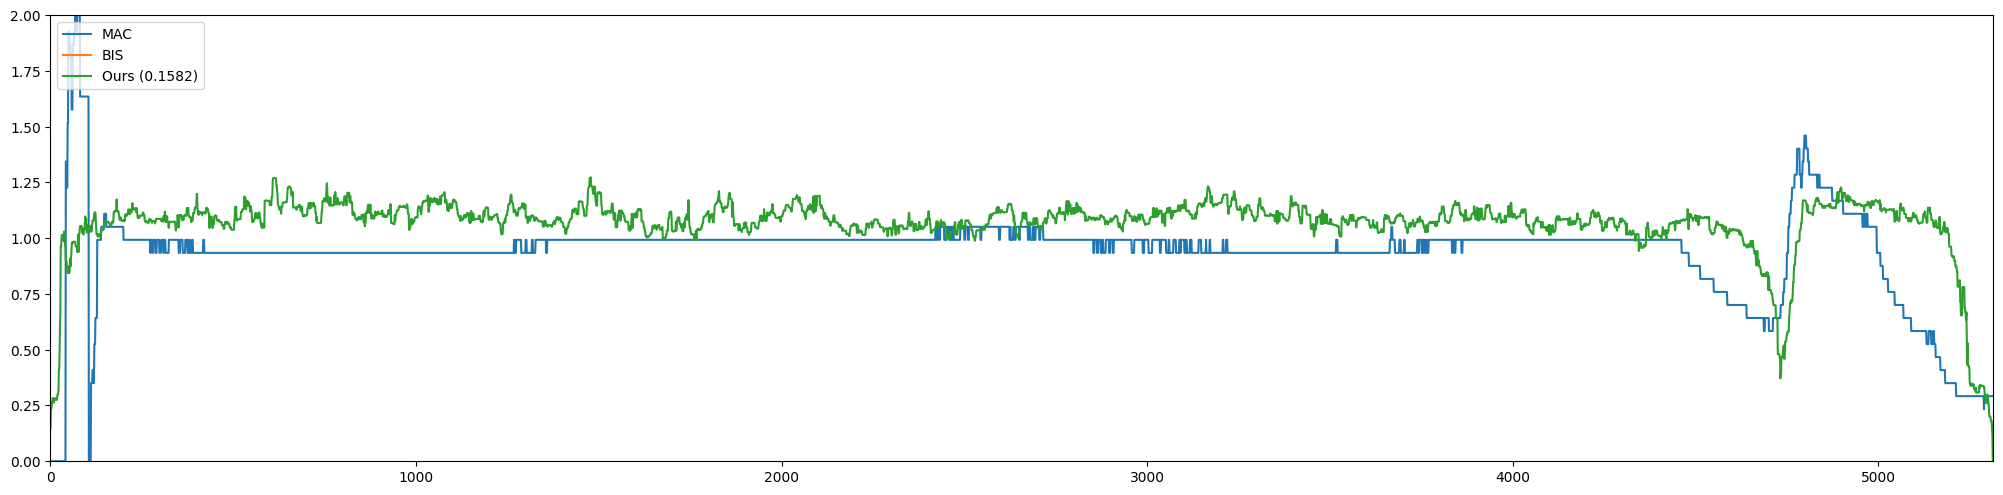

Total MAE=0.3646, CaseID 92, MAE=0.1795


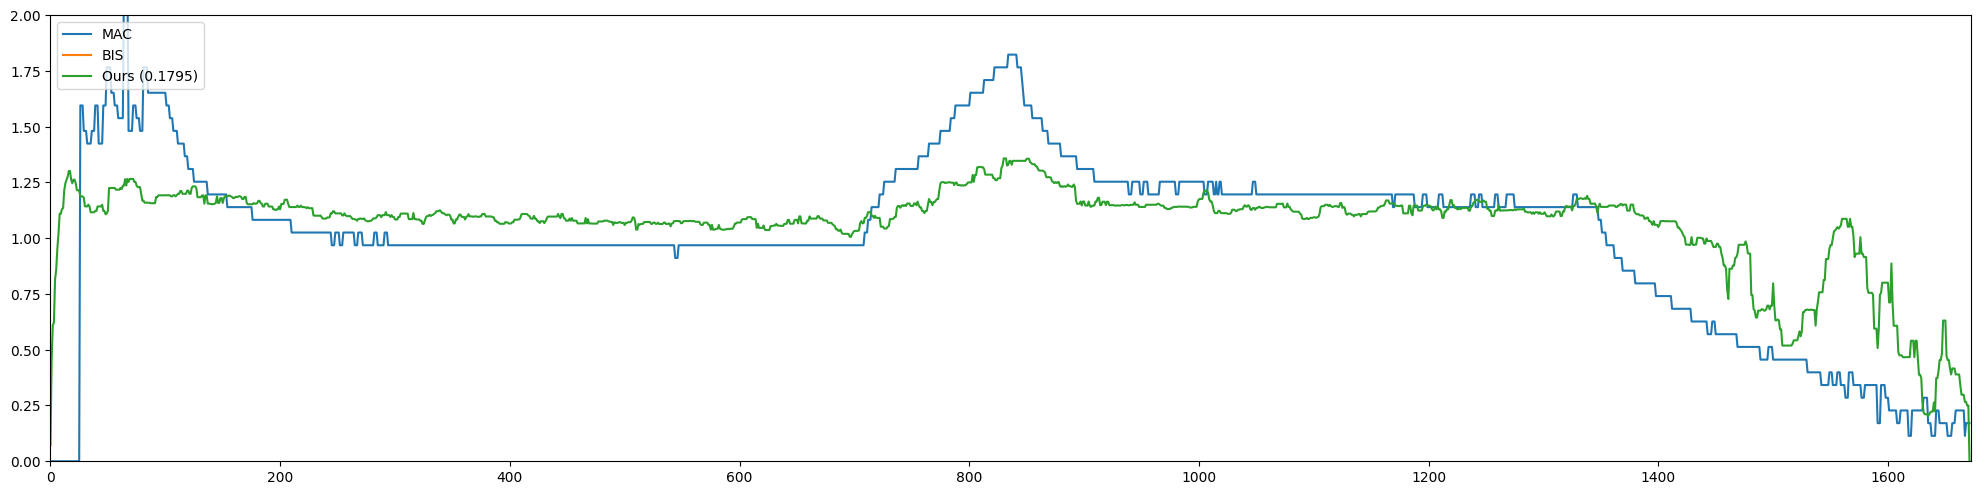

Total MAE=0.3646, CaseID 110, MAE=0.2537


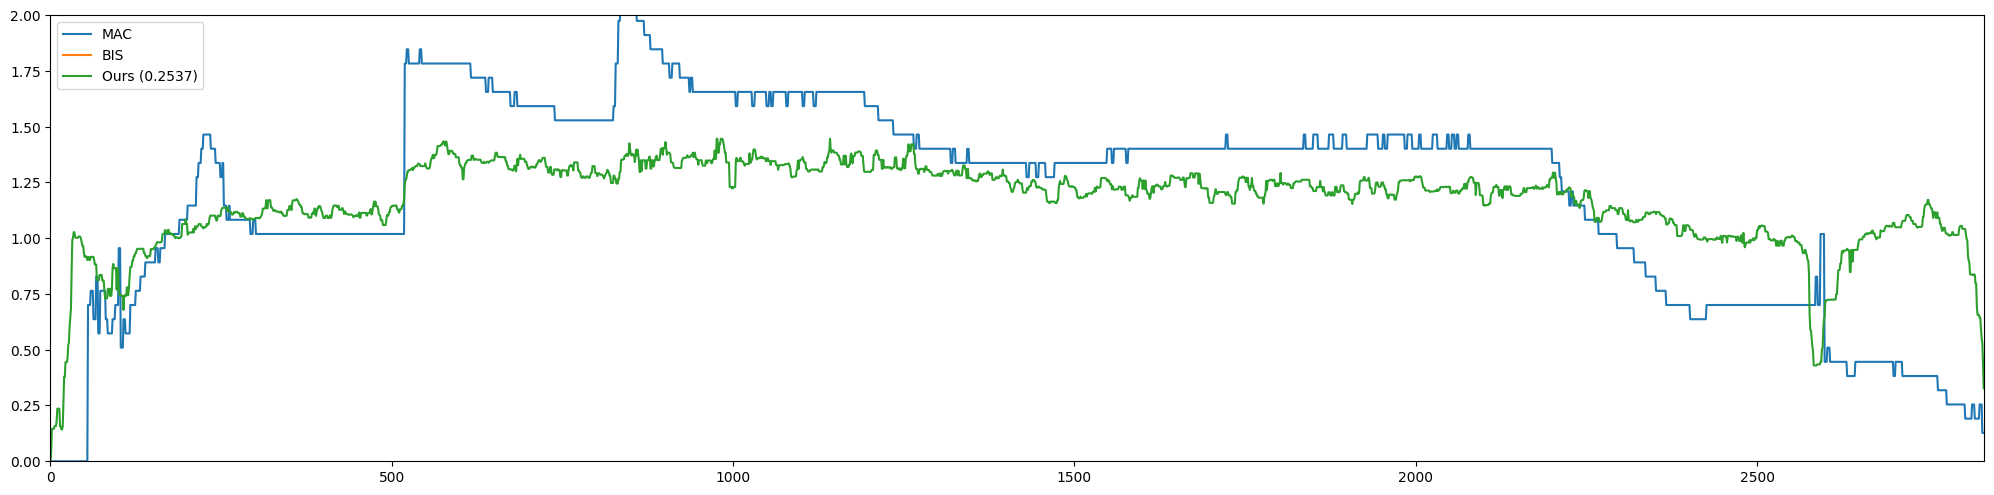

Total MAE=0.3646, CaseID 174, MAE=0.3301


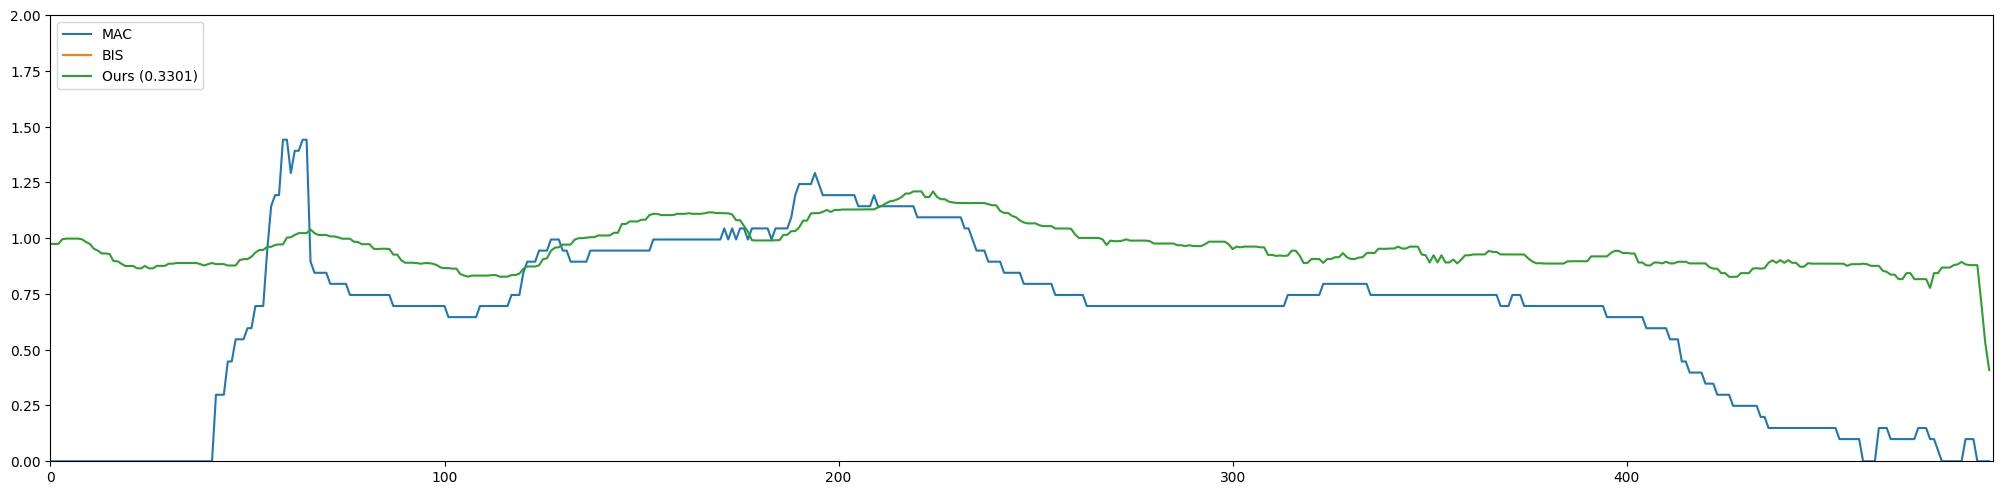

Total MAE=0.3646, CaseID 178, MAE=0.1559


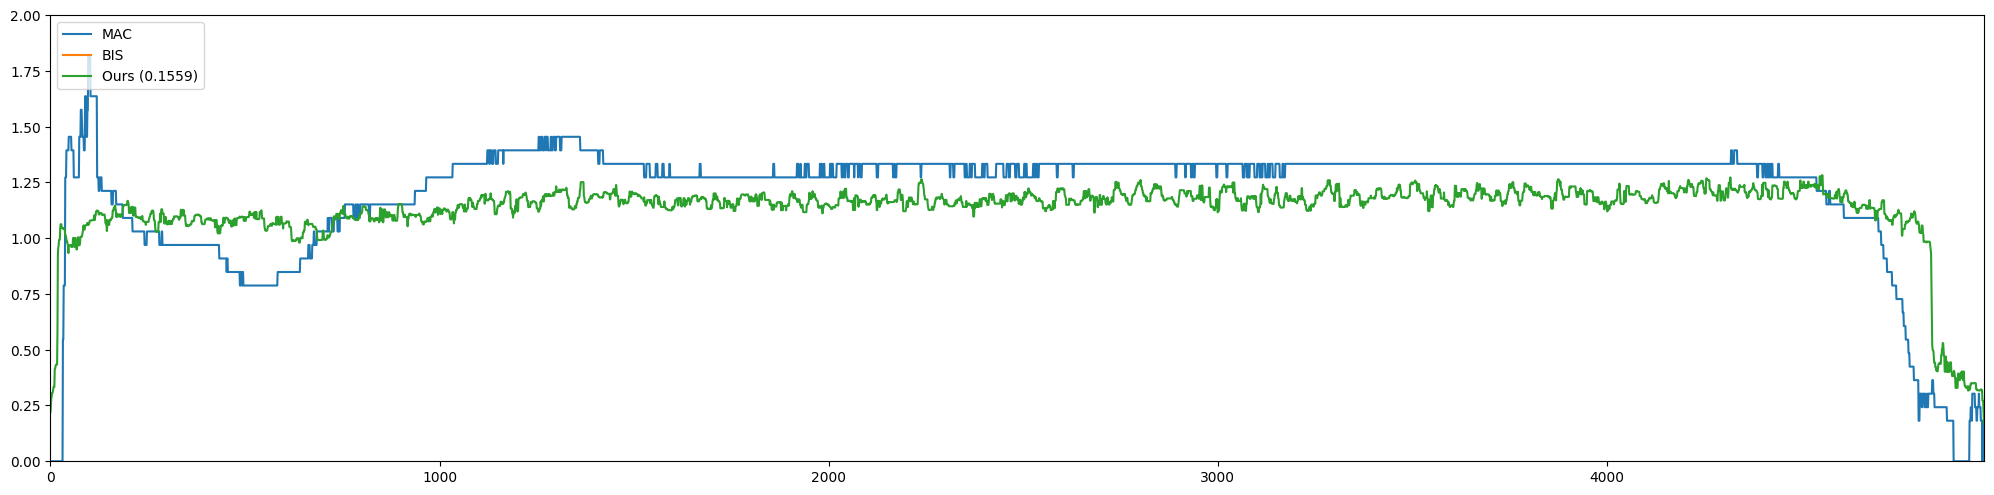

Total MAE=0.3646, CaseID 190, MAE=0.1971


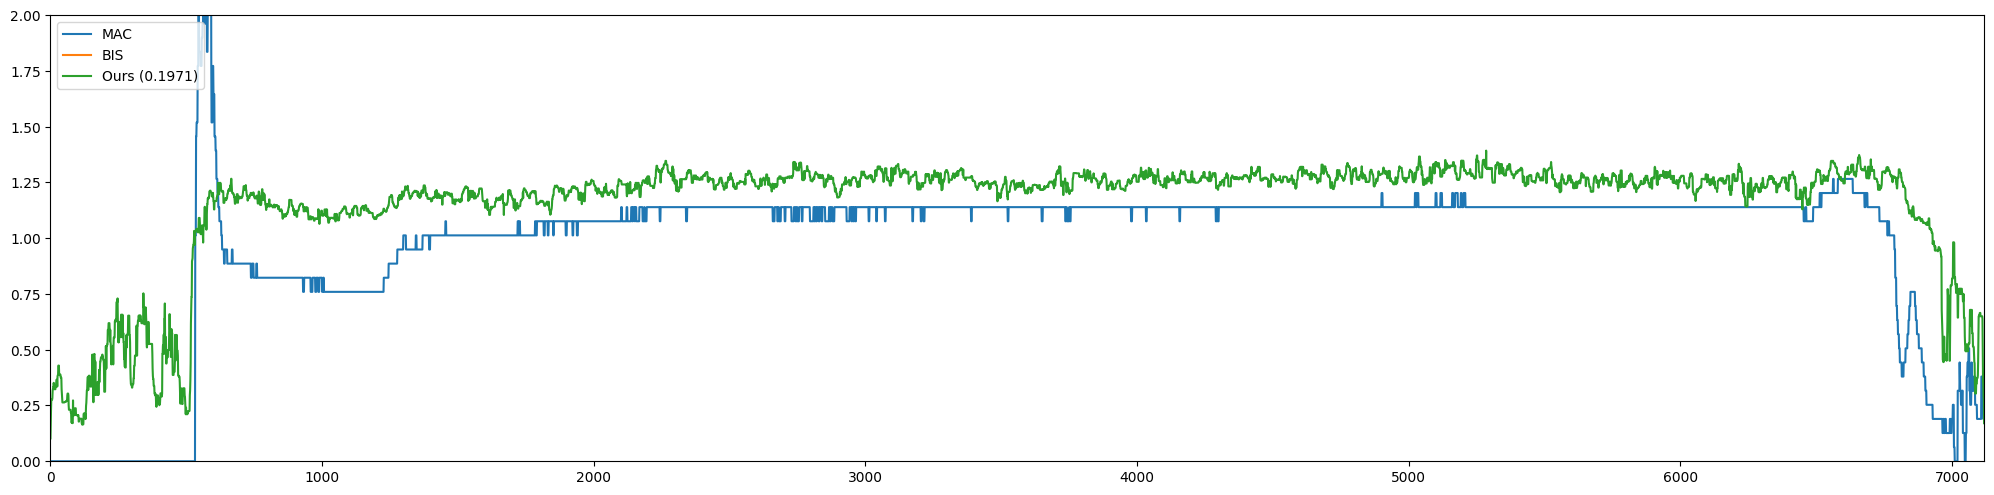

Total MAE=0.3646, CaseID 238, MAE=0.2980


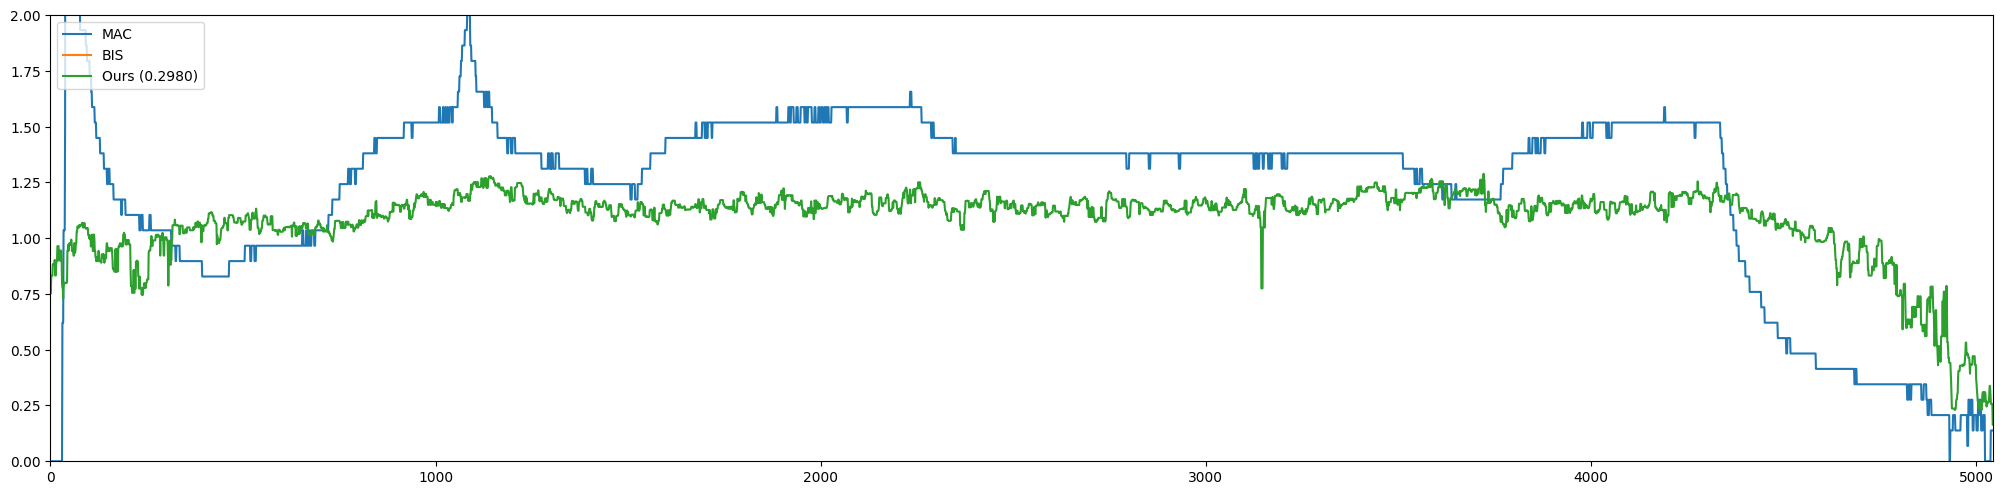

Total MAE=0.3646, CaseID 244, MAE=0.2970


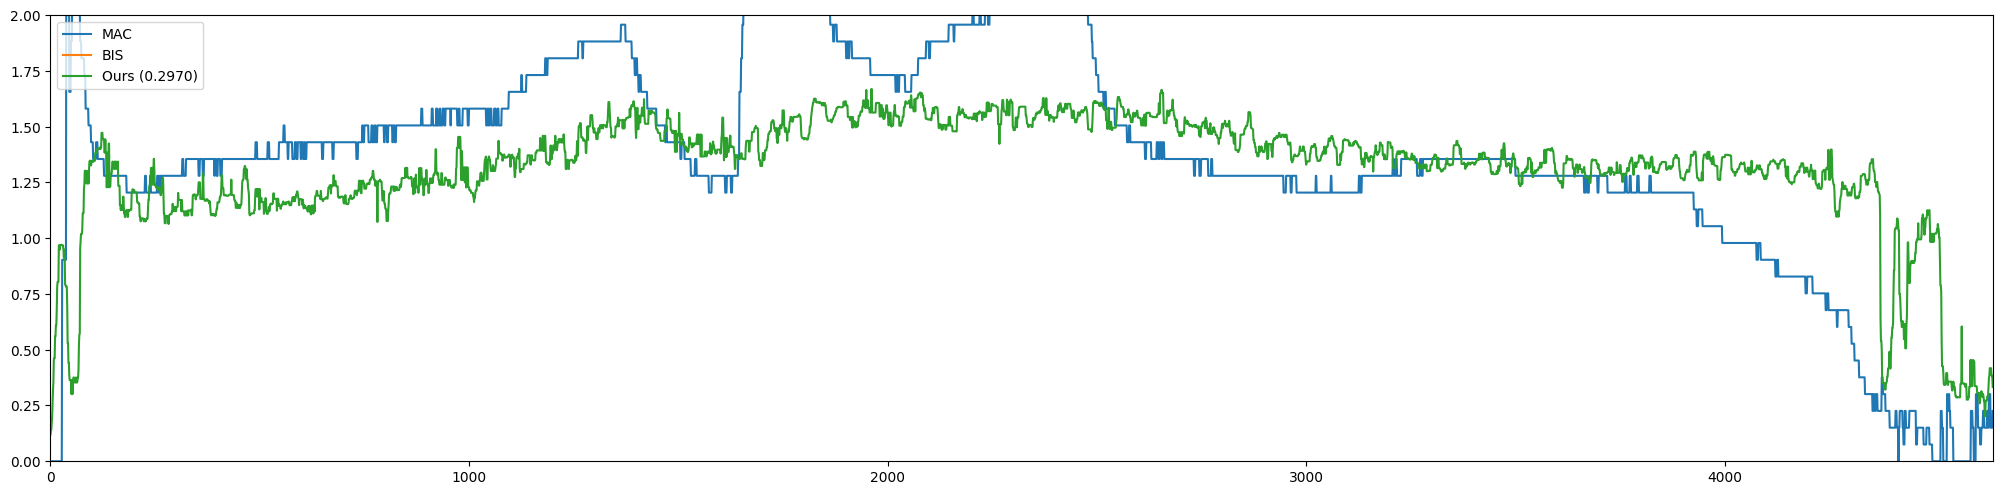

Total MAE=0.3646, CaseID 269, MAE=0.2377


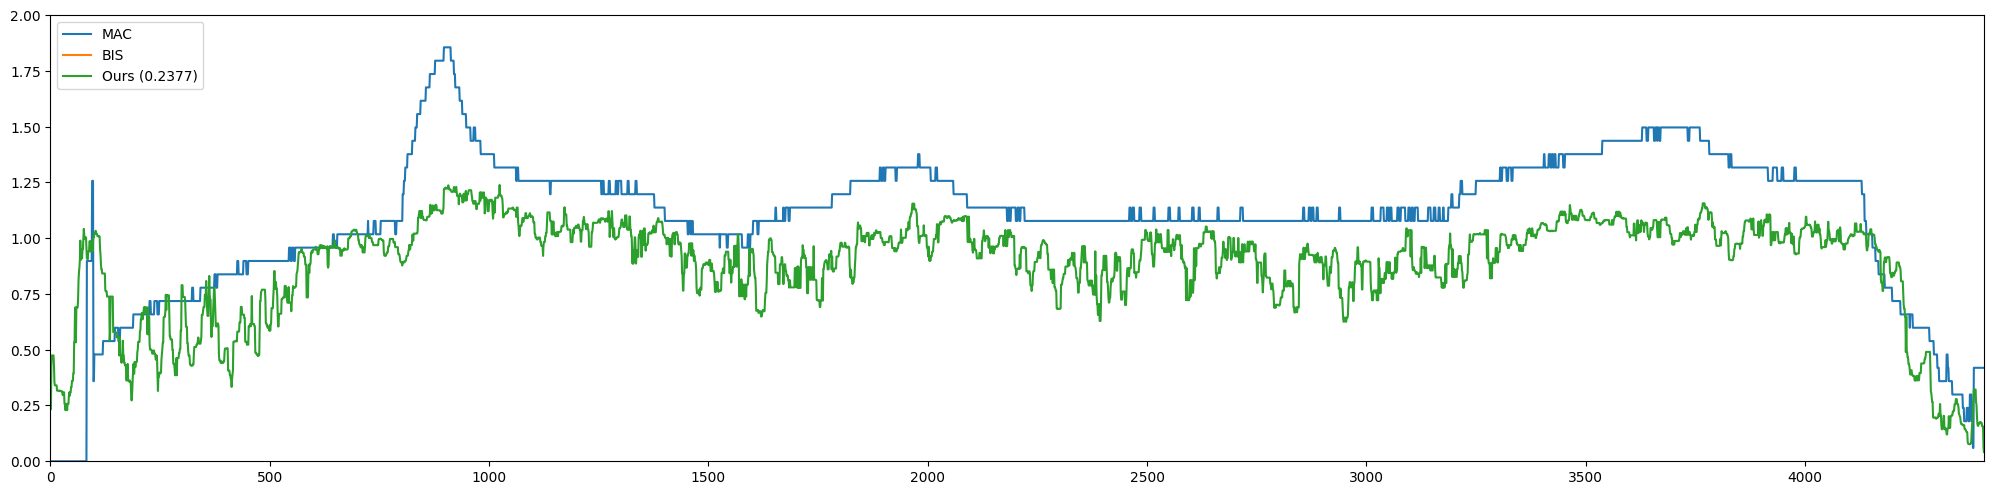

Total MAE=0.3646, CaseID 304, MAE=0.0842


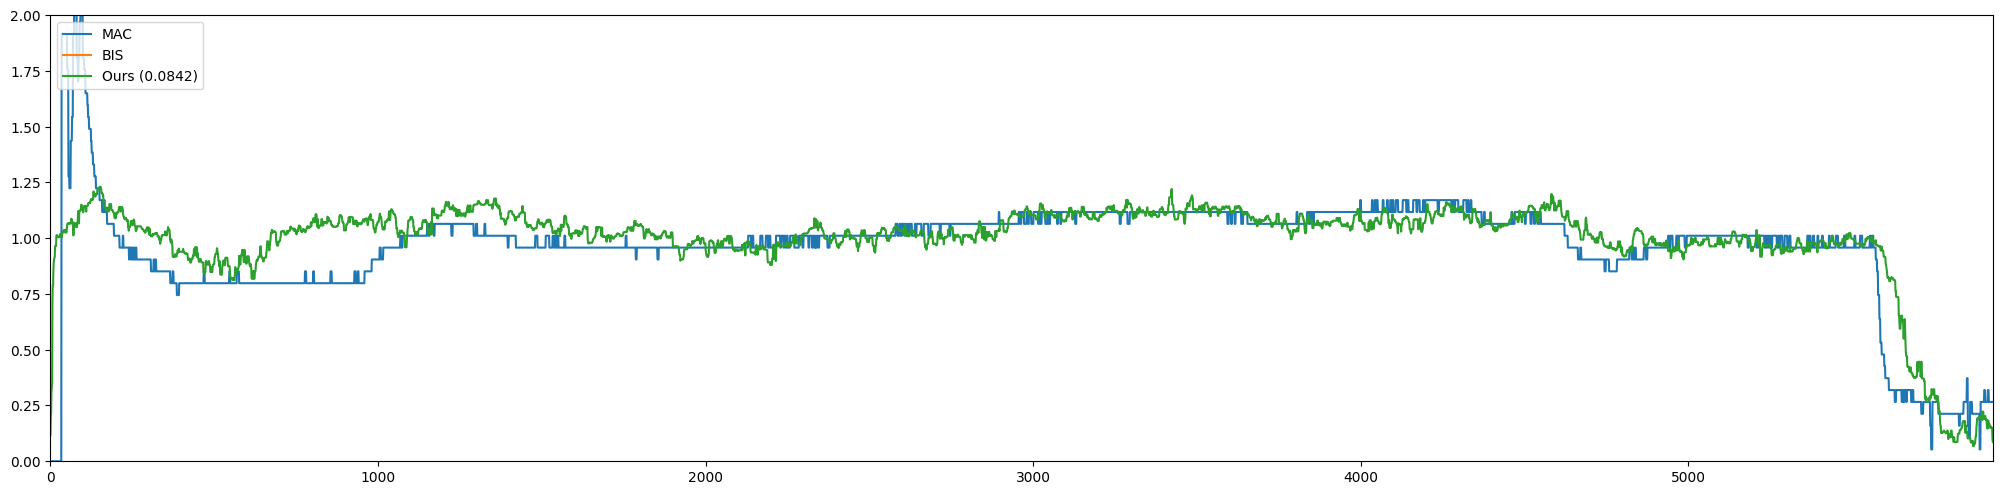

Total MAE=0.3646, CaseID 328, MAE=0.2559


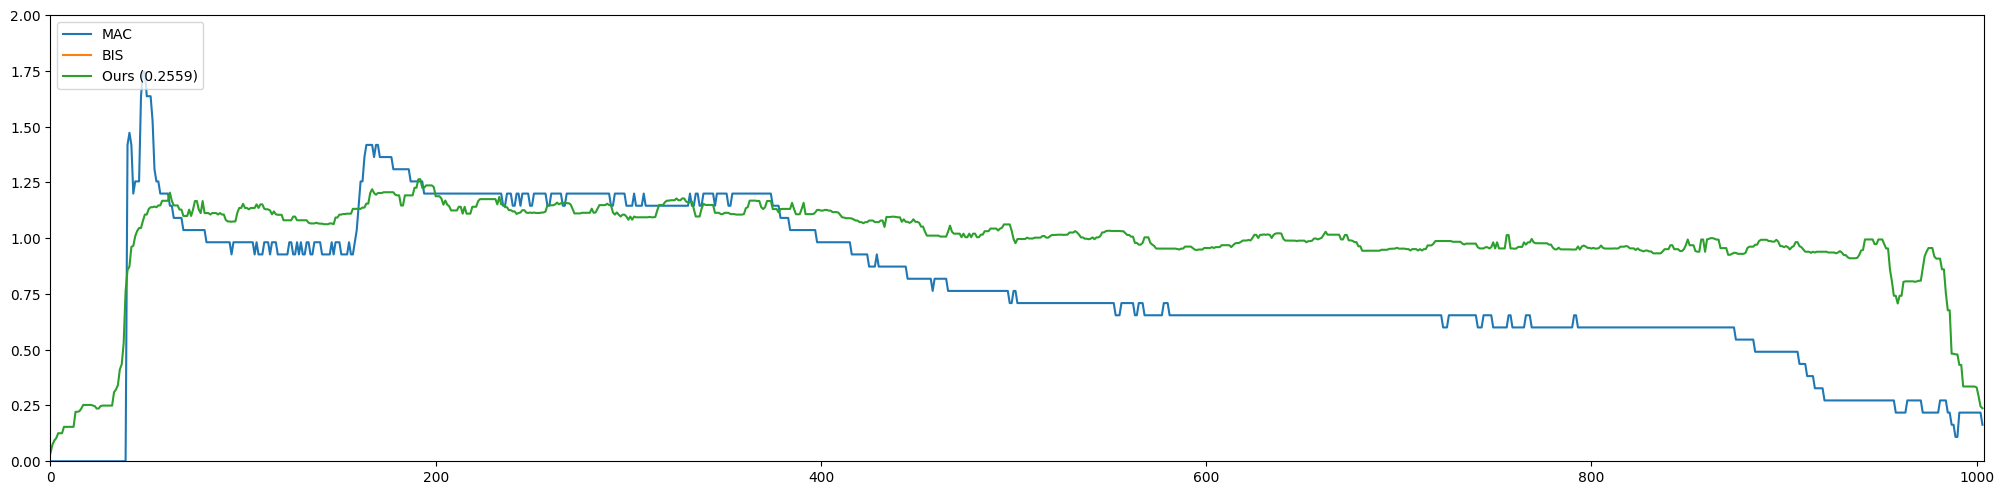

Total MAE=0.3646, CaseID 358, MAE=1.0717


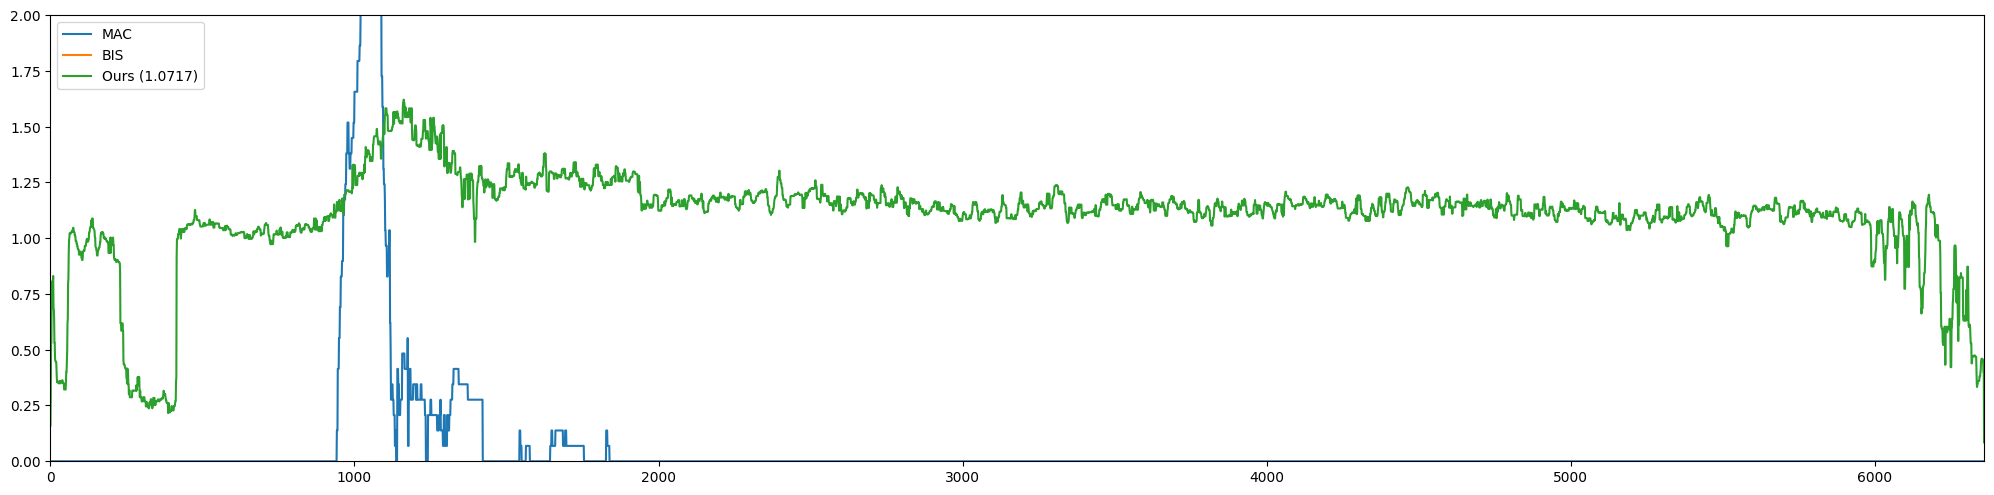

Total MAE=0.3646, CaseID 376, MAE=0.3079


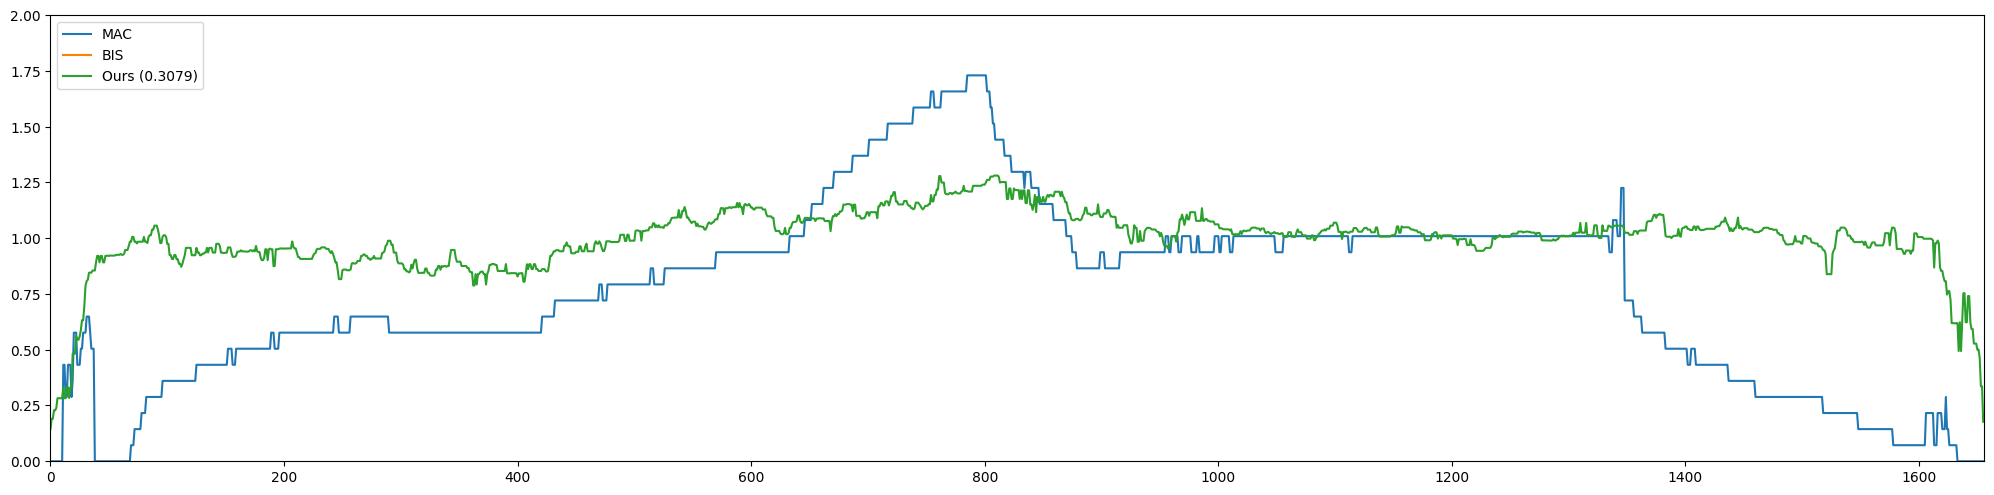

Total MAE=0.3646, CaseID 391, MAE=0.9967


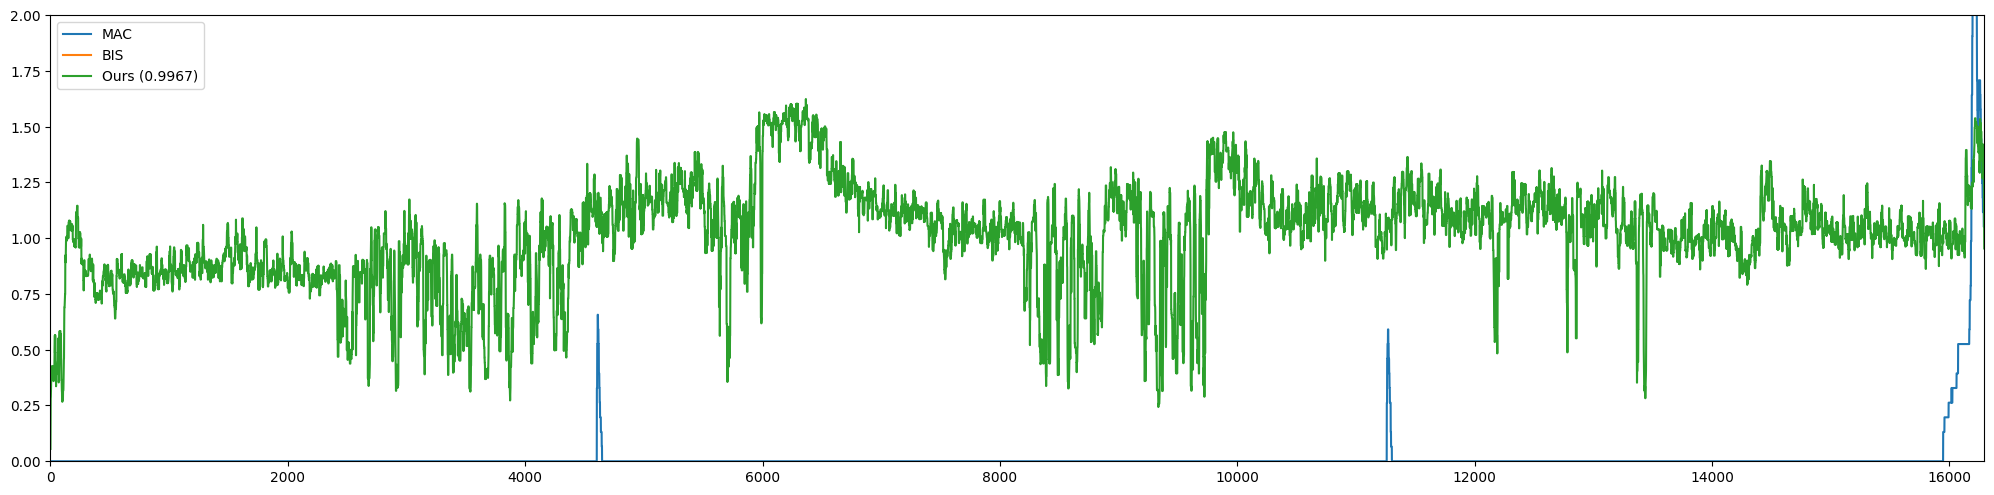

Total MAE=0.3646, CaseID 407, MAE=0.2628


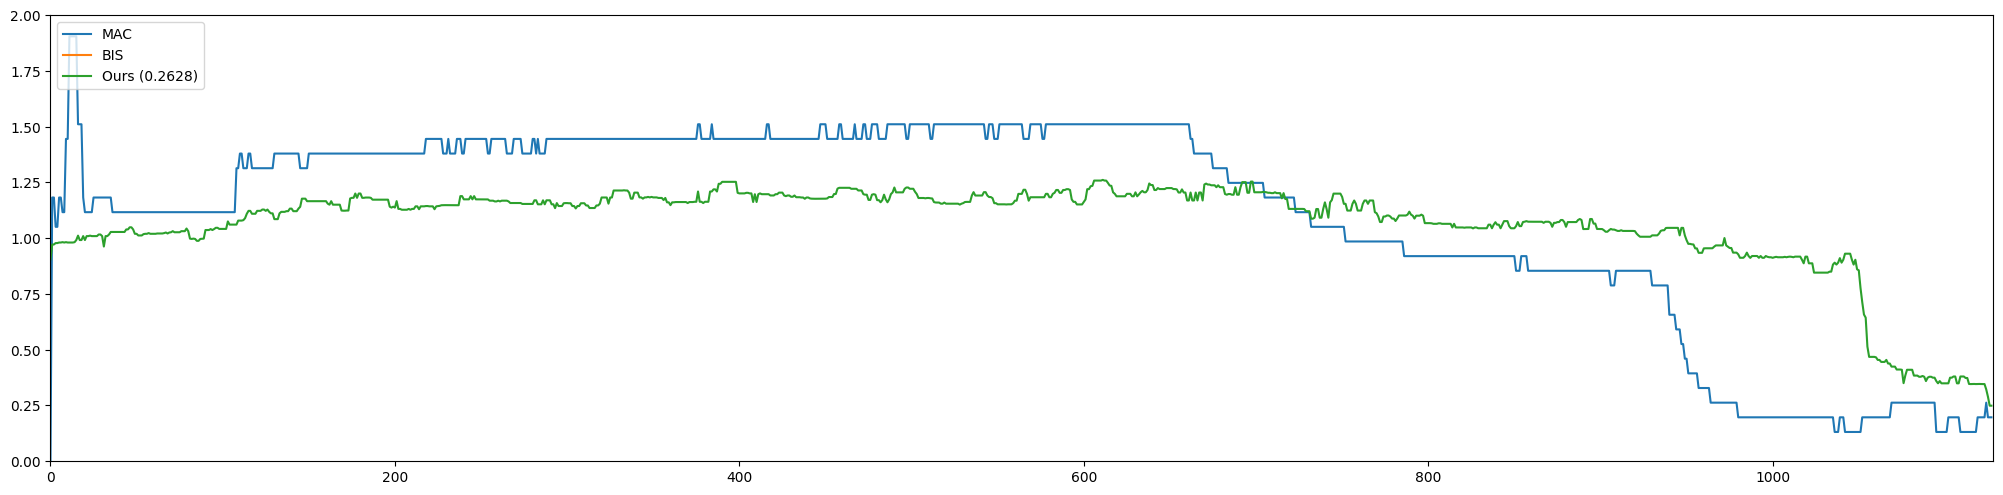

In [23]:
# plot for each case
for caseid in np.unique(c_test):
    case_mask = (c_test == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    our_mae = np.mean(np.abs(y_test[case_mask] - pred_test[case_mask]))
    print(f'Total MAE={test_mae:.4f}, CaseID {caseid}, MAE={our_mae:.4f}')

    t = np.arange(0, case_len)
    plt.figure(figsize=(20, 5))
    plt.plot(t, y_test[case_mask], label='MAC')
    plt.plot(t, b_test[case_mask], label='BIS')
    plt.plot(t, pred_test[case_mask], label=f'Ours ({our_mae:.4f})')
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.xlim([0, case_len])
    plt.ylim([0, 2])
    plt.show()